In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

In [16]:
%load_ext autoreload
%autoreload 2

In [4]:
%cd ../..

/n/home10/rdeshpande/morphogenesis/jax-morph


In [120]:
import matplotlib.pyplot as plt
import jax.numpy as np
plt.rcParams.update({'font.size': 25})

from jax import random, vmap
from jax_md import space, quantity, util
import jax_md.dataclasses as jdc

########## IMPORT JAX-MORPH FUNCTIONS ##########
################################################

from jax_morph.datastructures import SpaceFunc
from jax_morph.utils import _maybe_array, logistic
from jax_morph.simulation import simulation, sim_trajectory

# IMPORT STATE-CHANGING FUNCTIONS
from jax_morph.division_and_growth.cell_division import S_cell_division, S_cell_div_indep, S_cell_div_indep_MC
from jax_morph.division_and_growth.cell_growth import S_grow_cells

from jax_morph.mechanics.morse import S_mech_morse_relax
from jax_morph.cell_internals.stress import S_set_stress
from jax_morph.chemicals.secdiff import S_ss_chemfield

from jax_morph.cell_internals.divrates import S_set_divrate, div_nn
from jax_morph.cell_internals.secretion import sec_nn
from jax_morph.cell_internals.grad_estimate import S_chemical_gradients
from jax_morph.cell_internals.hidden_state import hidden_state_nn, S_hidden_state

from jax_morph.initial_states import init_state_grow

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate, draw_circles
from Ramya.mech_homogeneous_growth.chemical import S_fixed_chemfield

from functools import partial
import equinox as eqx
import haiku as hk

# For saving data
import pickle
import os

In [136]:
from Ramya.paper import paper_utils
import warnings
warnings.filterwarnings('ignore')

# Loss curves

In [11]:
# Load optimization results
with open('Ramya/data/homogeneous_growth_100_grads', 'rb') as handle:
    grads = pickle.load(handle)
with open('Ramya/data/homogeneous_growth_100_loss', 'rb') as handle:
    loss = pickle.load(handle)
with open('Ramya/data/homogeneous_growth_100_params', 'rb') as handle:
    param = pickle.load(handle)

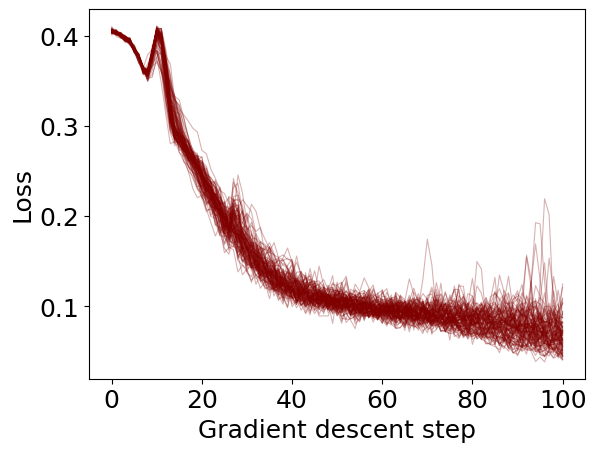

In [13]:
# Plot relevant losses
plt.plot(np.array(loss).T, color="maroon", alpha=0.3, linewidth=0.8);
plt.xlabel('Gradient descent step')
plt.ylabel('Loss');
plt.savefig('../data/paper/figures/loss_power_law.svg')

# Forward simulations

In [153]:
key = random.PRNGKey(0)
key, init_key = random.split(key)
Dparams, Dtrain_params = paper_utils.default_params(init_key)

In [154]:
key, subkey = random.split(key)
sim = paper_utils.build_sim_from_params(Dparams, Dtrain_params, subkey)
sim_init, sim_step = simulation(sim.fstep, sim.params, sim.fspace)

In [111]:
# Run 100 different forward simulations with optimized results
def run_sim(key, sim_init, sim_step, params, istate, num_steps):
    sim_init, sim_step = simulation(fstep, params, fspace)
    fstate, _ = sim_trajectory(istate, sim_init, sim_step, num_steps, key, history=False)
    return fstate
run_sim_vmap = vmap(run_sim, in_axes=(0, None, None, None, None, None))

In [155]:
# Filter out lowest loss parameters
# Add dummy key for now until I run updated optimization
Dparams["n_ones_init"] = 100
Dparams["chem_gamma"] = 0.1
Dparams["chem_k"] = 25
Dparams["eps_TwoTwo"] = 3.0
Dparams["eps_OneTwo"] = 3.0
Dparams["epsilon"] = Dparams["eps_OneOne"]

In [156]:
opt_filtered = np.argwhere(np.array(loss)[:, -1] < 0.16)[0][0]
opt_params = eqx.combine(param[opt_filtered][-1], Dparams)

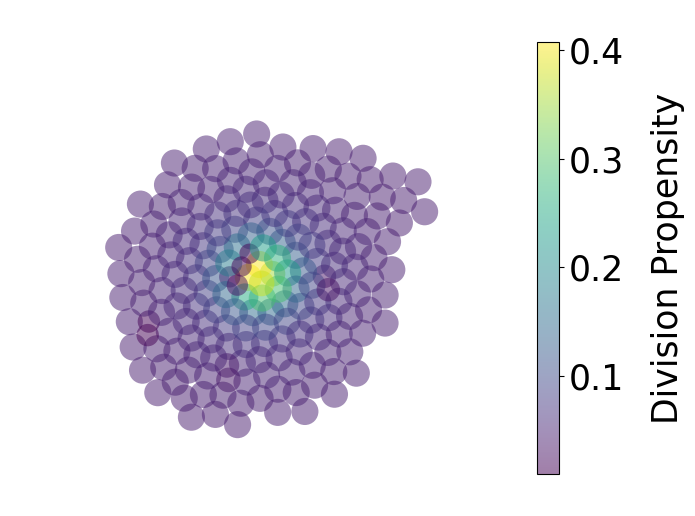

In [157]:
sim_init, sim_step = simulation(sim.fstep, Dparams, sim.fspace)
fstate_unopt, _ = sim_trajectory(sim.istate, sim_init, sim_step, 100, key, history=False)
draw_circles(fstate_unopt, fstate_unopt.divrate, cm=plt.cm.viridis, normalize=False, cbar_title="Division Propensity");
plt.savefig('../data/paper/figures/divrates_unopt.svg')

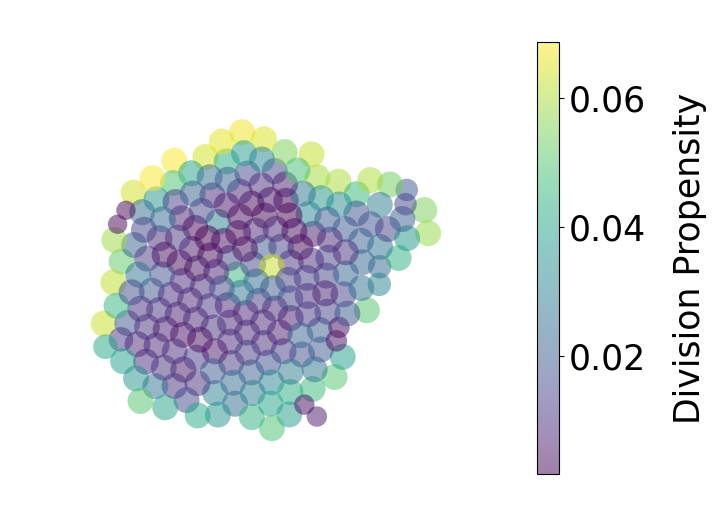

In [158]:
sim_init, sim_step = simulation(sim.fstep, opt_params, sim.fspace)
fstate_opt, _ = sim_trajectory(sim.istate, sim_init, sim_step, 100, key, history=False)
draw_circles(fstate_opt, fstate_opt.divrate, cm=plt.cm.viridis, normalize=False, cbar_title="Division Propensity");
plt.savefig('../data/paper/figures/divrates_opt.svg')

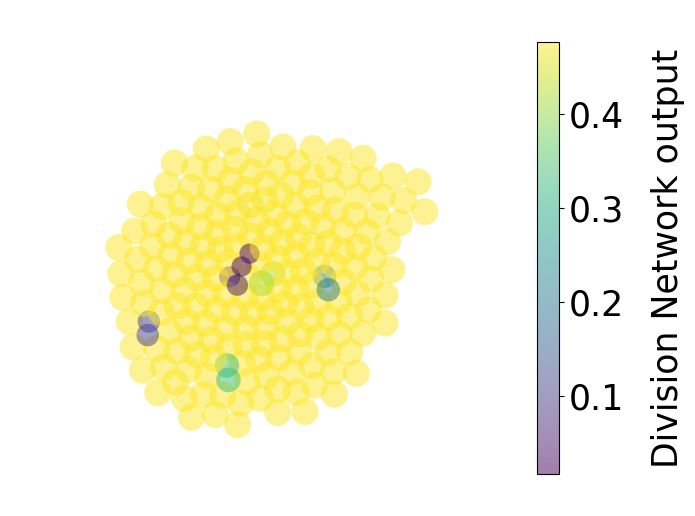

In [159]:
# Plot just division outputs (without scaling factor)
transform_fwd_inv = lambda state, divrates: divrates/logistic(state.field, 0.1, 25.0)
draw_circles(fstate_unopt, transform_fwd_inv(fstate_unopt, fstate_unopt.divrate), cm=plt.cm.viridis, normalize=False, cbar_title="Division Network output")
plt.savefig('../data/paper/figures/divoutputs_unopt.svg')

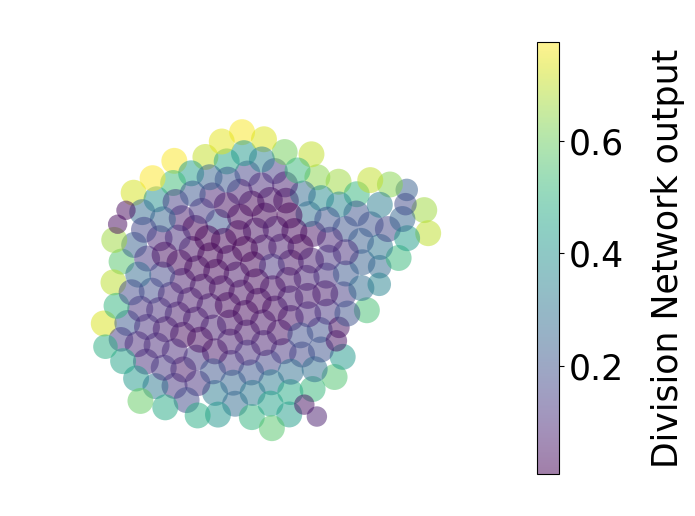

In [160]:
# Plot just division outputs (without scaling factor)
transform_fwd_inv = lambda state, divrates: divrates/logistic(state.field, 0.1, 25.0)
draw_circles(fstate_opt, transform_fwd_inv(fstate_opt, fstate_opt.divrate), normalize=False, cm=plt.cm.viridis, cbar_title="Division Network output")
plt.savefig('../data/paper/figures/divoutputs_opt.svg')

# Mechanism

In [64]:
# Make range of N numbers from 5th to 95th percentile of value
from jax.nn import leaky_relu
def make_range(N, traj_vals):
    return np.linspace(np.percentile(traj_vals.flatten(), 5), np.percentile(traj_vals.flatten(), 95), N) 
# Internal guts of the networks

# Hidden
n_hidden = [8]
transform_mlp_out=tanh
def _hidden_nn(in_fields):
    mlp = hk.nets.MLP(n_hidden+[params['hidden_state_size']],
                        activation=leaky_relu,
                        w_init=None,
                        activate_final=False
                        )
        
    out = mlp(in_fields)
    out = transform_mlp_out(out)

    return out
_hidden_nn = hk.without_apply_rng(hk.transform(_hidden_nn))

# Division
n_hidden_div, n_hidden_sec = [], []
transform_mlp_out = sigmoid
def _div_nn(in_fields):
    mlp = hk.nets.MLP(n_hidden_div+[1],
                      activation=leaky_relu,
                      activate_final=False,
                      w_init=hk.initializers.Constant(0.0),
                        )
        
    out = mlp(in_fields)
    out = transform_mlp_out(out)
    return out
_div_nn = hk.without_apply_rng(hk.transform(_div_nn))

# Secretion
def _sec_nn(in_fields):
    mlp = hk.nets.MLP(n_hidden_sec+[params['n_chem']],
                        activation=leaky_relu,
                        activate_final=False,
                        w_init=hk.initializers.Constant(0.0),
                        )
        
    out = mlp(in_fields)
    out = transform_mlp_out(out)
    return out
_sec_nn = hk.without_apply_rng(hk.transform(_sec_nn))

In [65]:
# Plot div_nn output for different values of chemicals and stresses
def get_div_output(key, params_to_use, traj, c=0):
        chem1 = np.median(traj[0].chemical[:, :, 1 - c].flatten())
        chem2 = make_range(20, traj[0].chemical[:, :, c])
        chem1_x = np.median(traj[0].chemgrad[:, :, 0])
        chem1_y = np.median(traj[0].chemgrad[:, :, 1])
        chem2_x = np.median(traj[0].chemgrad[:, :, 2])
        chem2_y = np.median(traj[0].chemgrad[:, :, 3])
        stress_range = make_range(20, traj[0].stress[:])
        x, y = np.meshgrid(chem2, stress_range)
        plotting_data = (x, y)
        input_data = np.vstack((np.repeat(chem1, 400), x.flatten(), np.repeat(chem1_x, 400), np.repeat(chem1_y, 400), np.repeat(chem2_x, 400), np.repeat(chem2_y, 400), y.flatten())).T
        _ = _hidden_nn.init(key, np.ones(input_data.shape))
        hidden_output = _hidden_nn.apply(params_to_use["hidden_fn"].copy(), input_data)
        _ = _div_nn.init(key, np.ones(np.array(hidden_output).shape))
        div_output = _div_nn.apply(params_to_use["div_fn"].copy(), hidden_output).flatten()
        return plotting_data, div_output

In [66]:
# Plot div_nn output for different values of chemicals and stresses
def get_sec_output(key, params_to_use, traj, c=0):
        chem1 = np.median(traj[0].chemical[:, :, 1 - c].flatten())
        chem2 = make_range(20, traj[0].chemical[:, :, c])
        chem1_x = np.median(traj[0].chemgrad[:, :, 0])
        chem1_y = np.median(traj[0].chemgrad[:, :, 1])
        chem2_x = np.median(traj[0].chemgrad[:, :, 2])
        chem2_y = np.median(traj[0].chemgrad[:, :, 3])
        stress_range = make_range(20, traj[0].stress[:])
        x, y = np.meshgrid(chem2, stress_range)
        plotting_data = (x, y)
        input_data = np.vstack((np.repeat(chem1, 400), x.flatten(), np.repeat(chem1_x, 400), np.repeat(chem1_y, 400), np.repeat(chem2_x, 400), np.repeat(chem2_y, 400), y.flatten())).T
        _ = _hidden_nn.init(key, np.ones(input_data.shape))
        hidden_output = _hidden_nn.apply(params_to_use["hidden_fn"].copy(), input_data)
        _ = _sec_nn.init(key, np.ones(np.array(hidden_output).shape))
        sec_output = _sec_nn.apply(params_to_use["sec_fn"].copy(), hidden_output).flatten()
        return plotting_data, sec_output

Text(0.5, 1.0, 'Chemical 2')

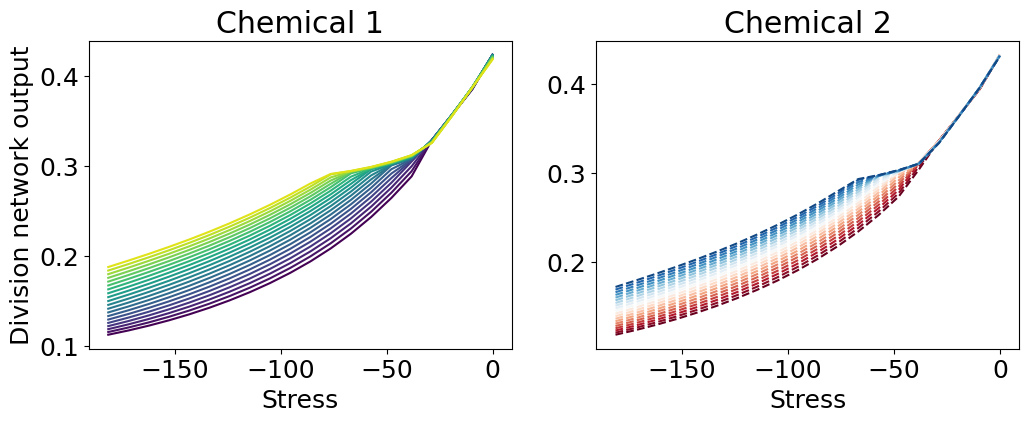

In [67]:
#for i, p in enumerate(params_all[2]):
# 8
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
p = params_all[12]
i = 2
sim_init, sim_step = simulation(fstep, p, fspace)
opt_fstate, opt_traj = sim_trajectory(istate, sim_init, sim_step, 100, key, history=True)
(x, y), div_output = get_div_output(key, p.copy(), opt_traj)
(x2, y2), div_output2 = get_div_output(key, p.copy(), opt_traj, c=1)

for j in range(20):
    ax[0].plot(y.T[j], div_output.reshape(20, 20).T[j], c=plt.cm.viridis(j/20));
    ax[1].plot(y2.T[j], div_output2.reshape(20, 20).T[j], c=plt.cm.RdBu(j/20), linestyle="dashed");
ax[0].set_xlabel("Stress")
ax[1].set_xlabel("Stress")
ax[0].set_ylabel("Division network output")
ax[0].set_title("Chemical 1")
ax[1].set_title("Chemical 2")

Text(0.5, 1.0, 'Chemical 2')

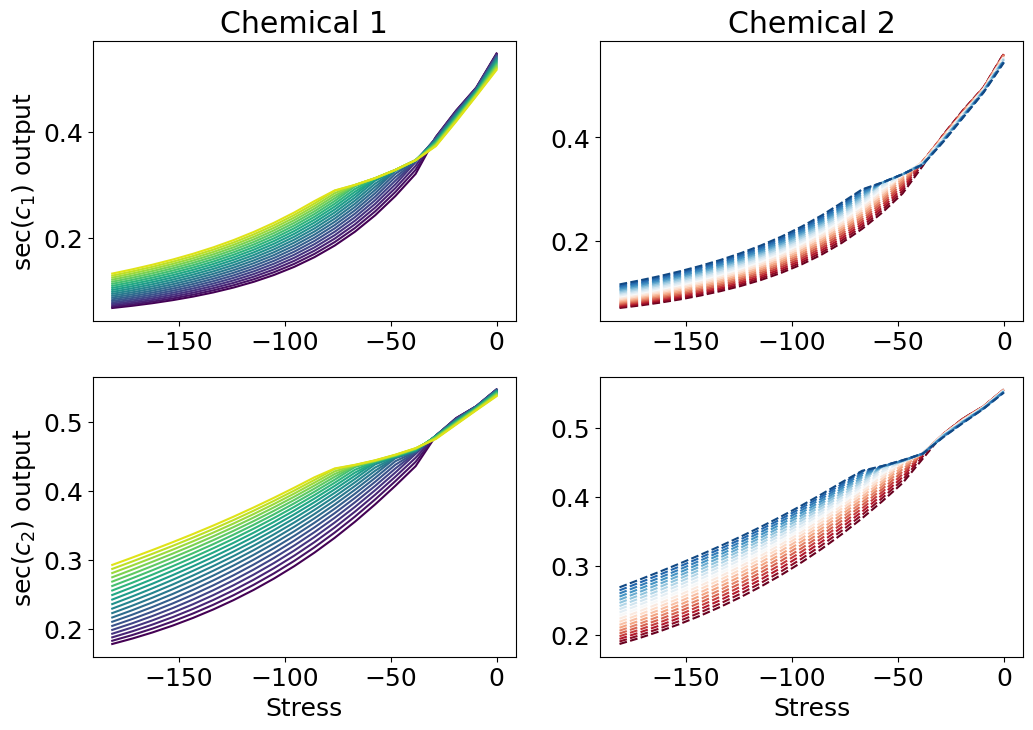

In [68]:
#for i, p in enumerate(params_all[2]):
# 8
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
p = params_all[12]
i = 2
sim_init, sim_step = simulation(fstep, p, fspace)
opt_fstate, opt_traj = sim_trajectory(istate, sim_init, sim_step, 100, key, history=True)
(x, y), sec_output = get_sec_output(key, p.copy(), opt_traj)
(x2, y2), sec_output2 = get_sec_output(key, p.copy(), opt_traj, c=1)

for j in range(20):
    ax[0][0].plot(y.T[j], sec_output.reshape(20, 20, 2).T[0, j], c=plt.cm.viridis(j/20));
    ax[0][1].plot(y2.T[j], sec_output2.reshape(20, 20, 2).T[0, j], c=plt.cm.RdBu(j/20), linestyle="dashed");
    ax[1][0].plot(y.T[j], sec_output.reshape(20, 20, 2).T[1, j], c=plt.cm.viridis(j/20));
    ax[1][1].plot(y2.T[j], sec_output2.reshape(20, 20, 2).T[1, j], c=plt.cm.RdBu(j/20), linestyle="dashed");
ax[1][0].set_xlabel("Stress")
ax[1][1].set_xlabel("Stress")
ax[0][0].set_ylabel(r"sec($c_1$) output")
ax[1][0].set_ylabel(r"sec($c_2$) output")
ax[0][0].set_title("Chemical 1")
ax[0][1].set_title("Chemical 2")

# Chemical field change

In [161]:
def exp_chemfield(state, params, fspace, chem_max=50.0, chem_k=1.0):
    center = np.array([0.0, 0.0])
    chemfield_disp = vmap(fspace.displacement, (0, None))(state.position, center)
    chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
    chemfield = chem_max*np.exp(-chem_k*chemfield_disp)
    chemfield = np.where(state.celltype > 0, chemfield, 0.0) 
    state = jdc.replace(state, field=chemfield)
    return state

In [162]:
def power_chemfield(state, params, fspace, chem_max=50.0, chem_k=1.0):
    center = np.array([0.0, 0.0])
    chemfield_disp = vmap(fspace.displacement, (0, None))(state.position, center)
    chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
    chemfield = chem_max/(1 + chem_k*np.power(chemfield_disp, 2))
    chemfield = np.where(state.celltype > 0, chemfield, 0.0) #+ noise*random.normal(istate.key, chemfield.shape)
    state = jdc.replace(state, field=chemfield)
    return state

In [163]:
# Run simulation for different chemical fields
def run_sim_field(key, chem_k, chem_max, chem_function, sim_init, sim_step, p, istate, num_steps):
    fstep = [
    # ENV CHANGES
    S_cell_division,
    S_grow_cells,
    partial(S_mech_morse_relax, dt=.0001),
    partial(S_ss_chemfield, sec_fn=sec_nn_apply, n_iter=3),
    # SENSING
    #chemicals sensed directly
    S_chemical_gradients,
    partial(chem_function, chem_max=chem_max, chem_k=chem_k),
    S_set_stress,
    # INTERNAL (HIDDEN) STATE
    partial(S_hidden_state, dhidden_fn=eqx.filter_jit(hid_nn_apply), state_decay=.0),
    # POLICIES
    partial(S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
    ]
    sim_init, sim_step = simulation(fstep, p, fspace)
    fstate, _ = sim_trajectory(istate, sim_init, sim_step, num_steps, key, history=False)
    return fstate
run_sim_field_vmap = vmap(run_sim_field, in_axes=(0, None, None, None, None, None, None, None, None))
run_sim_field_vmap_k = vmap(run_sim_field, in_axes=(0, 0, None, None, None, None, None, None, None))

In [35]:
keys = random.split(key, N)
unopt_fstates_power_k = run_sim_field_vmap_k(keys, power_ks, 50.0, power_chemfield, sim_init, sim_step, params, istate, 100)
opt_fstates_power_k = run_sim_field_vmap_k(keys, power_ks, 50.0, power_chemfield, sim_init, sim_step, params_all[0], istate, 100)
unopt_fstates_exp_k = run_sim_field_vmap_k(keys, exp_ks, 50.0, exp_chemfield, sim_init, sim_step, params, istate, 100)
opt_fstates_exp_k = run_sim_field_vmap_k(keys, exp_ks, 50.0, exp_chemfield, sim_init, sim_step, params_all[0], istate, 100)

Text(0, 0.5, 'CV divrates')

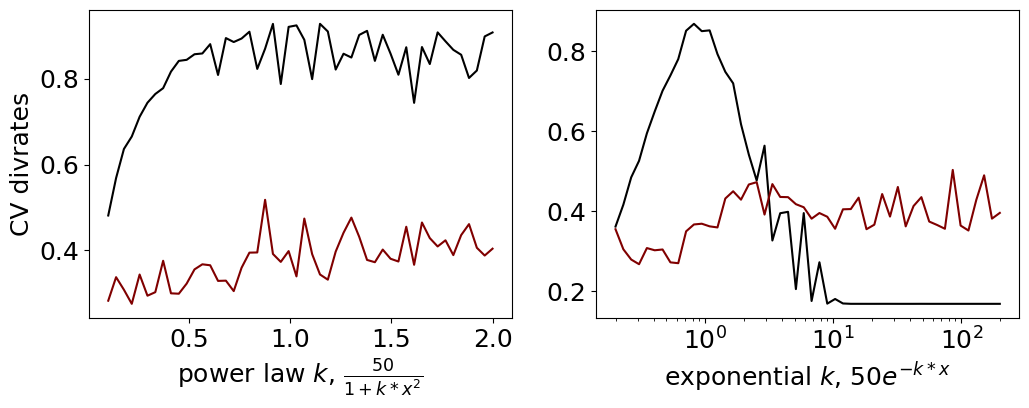

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(power_ks, np.std(unopt_fstates_power_k.divrate, axis=1)/np.mean(unopt_fstates_power_k.divrate, axis=1), color='black', label="unoptimized");
ax[0].plot(power_ks, np.std(opt_fstates_power_k.divrate, axis=1)/np.mean(opt_fstates_power_k.divrate, axis=1), color='maroon', label="optimized");
ax[1].plot(exp_ks, np.std(unopt_fstates_exp_k.divrate, axis=1)/np.mean(unopt_fstates_exp_k.divrate, axis=1), color='black', label="unoptimized");
ax[1].plot(exp_ks, np.std(opt_fstates_exp_k.divrate, axis=1)/np.mean(opt_fstates_exp_k.divrate, axis=1), color='maroon', label="optimized");
ax[0].set_xlabel(r"power law $k$, $\frac{50}{1 + k*x^2}$")
ax[1].set_xlabel(r"exponential $k$, $50e^{-k*x}$")
ax[1].set_xscale("log")
ax[0].set_ylabel("CV divrates")

# A "nutty" field

In [164]:
def gradient_chemfield(state, params, fspace, chem_max=50.0, chem_k=1.0):
    y_disp = state.position[:, 1] - state.position[:, 1].min()
    chemfield = 5.0*y_disp
    chemfield = np.where(state.celltype > 0, chemfield, 0.0) 
    state = jdc.replace(state, field=chemfield)
    return state

In [40]:
uopt_grad_fstate = run_sim_field(key, 0.0, 0.0, gradient_chemfield, sim_init, sim_step, params, istate, 100)
opt_grad_fstate = run_sim_field(key, 0.0, 0.0, gradient_chemfield, sim_init, sim_step, params_all[0], istate, 100)

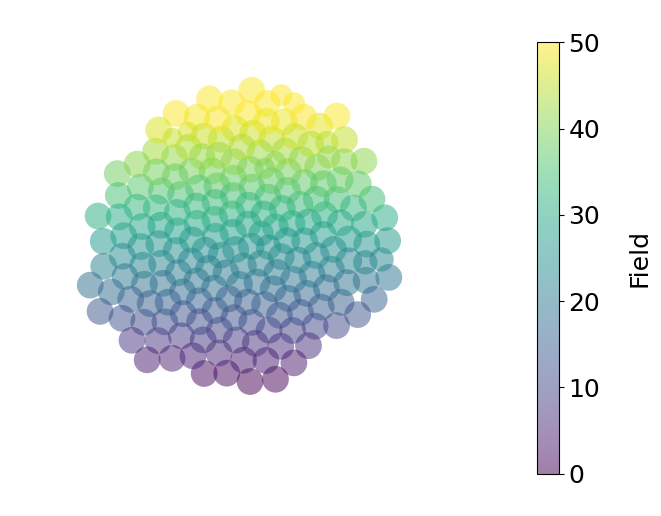

In [42]:
draw_circles(uopt_grad_fstate, uopt_grad_fstate.field, min_val=0.0, max_val=50.0, cm=plt.cm.viridis, cbar_title="Field");
plt.savefig('../data/paper/figures/gradfield_unopt_field.svg')

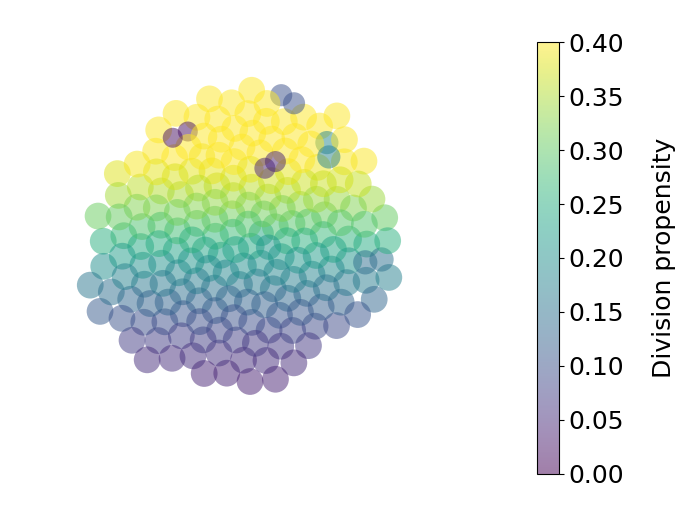

In [46]:
draw_circles(uopt_grad_fstate, uopt_grad_fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.4, cbar_title="Division propensity");
plt.savefig('../data/paper/figures/gradfield_unopt_divrates.svg')

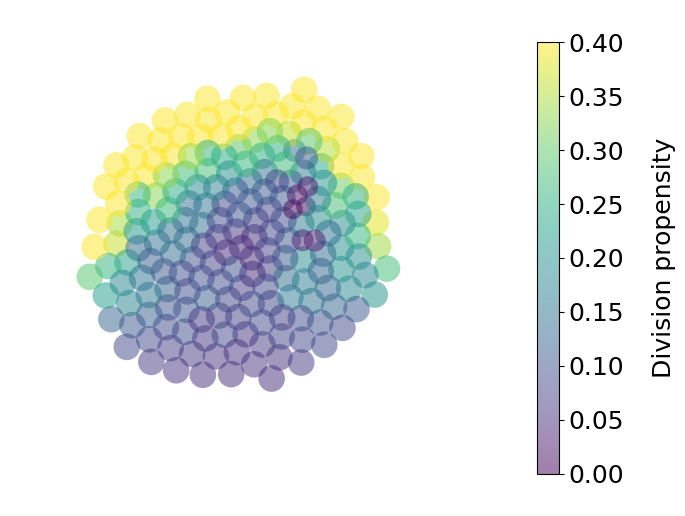

In [45]:
draw_circles(opt_grad_fstate, opt_grad_fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.4, cbar_title="Division propensity");
plt.savefig('../data/paper/figures/gradfield_opt_divrates.svg')

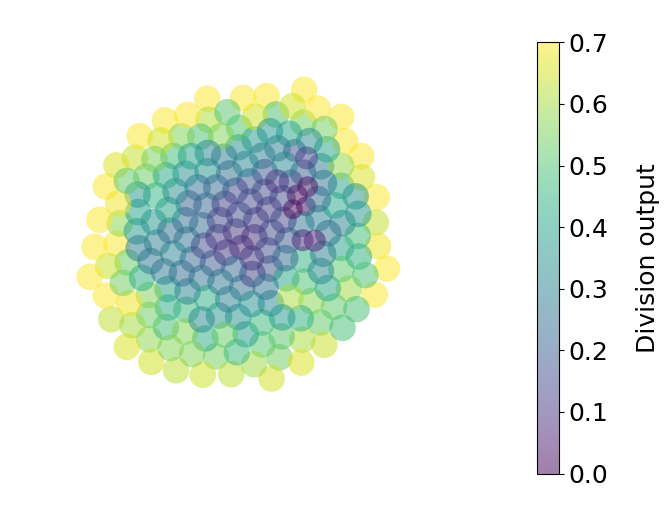

In [70]:
div_outputs = transform_fwd_inv(opt_grad_fstate, opt_grad_fstate.divrate)
draw_circles(opt_grad_fstate, div_outputs, cm=plt.cm.viridis, min_val=0.0, max_val=0.7, cbar_title="Division output");
plt.savefig('../data/paper/figures/gradfield_opt_divoutputs.svg')

In [21]:
def two_peaks_chemfield(state, params, fspace, chem_max=50.0, chem_k=1.0):
    centers = np.array([[-3.0, 0.0], [3.5, 0.0]])
    chemfield_disp1 = np.reshape(np.linalg.norm(vmap(fspace.displacement, (0, None))(state.position, centers[0]), axis=1), (-1, 1))
    chemfield_disp2 = np.reshape(np.linalg.norm(vmap(fspace.displacement, (0, None))(state.position, centers[1]), axis=1), (-1, 1))
    peak_mask = np.argmin(np.hstack((chemfield_disp1, chemfield_disp2)), axis=1)
    chemfield = np.where(peak_mask, chemfield_disp2[:, 0], chemfield_disp1[:, 0])
    chemfield = 100/(1 + 0.8*chemfield**2)
    state = jdc.replace(state, field=chemfield)
    return state

In [54]:
uopt_peaks_fstate = run_sim_field(key, 0.0, 0.0, two_peaks_chemfield, sim_init, sim_step, params, istate, 100)
opt_peaks_fstate = run_sim_field(key, 0.0, 0.0, two_peaks_chemfield, sim_init, sim_step, params_all[0], istate, 100)

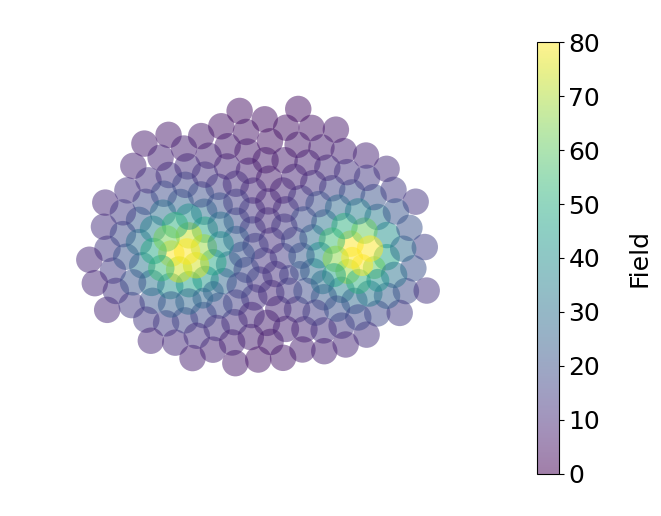

In [55]:
draw_circles(uopt_peaks_fstate, uopt_peaks_fstate.field, min_val=0.0, max_val=80.0, cm=plt.cm.viridis, cbar_title="Field");
plt.savefig('../data/paper/figures/twopeaks_unopt_field.svg')

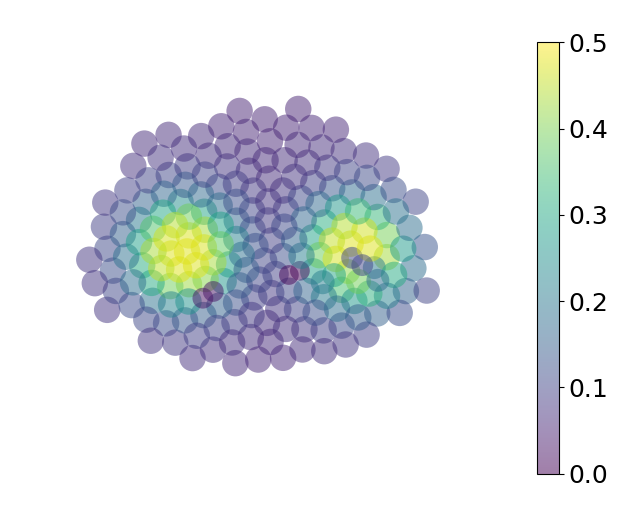

In [56]:
draw_circles(uopt_peaks_fstate, uopt_peaks_fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.5);
plt.savefig('../data/paper/figures/twopeaks_unopt_divrates.svg')

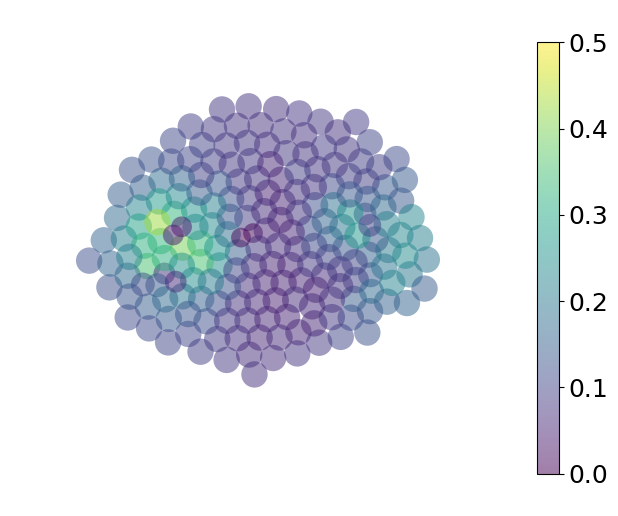

In [57]:
draw_circles(opt_peaks_fstate, opt_peaks_fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.5);
plt.savefig('../data/paper/figures/twopeaks_opt_divrates.svg')

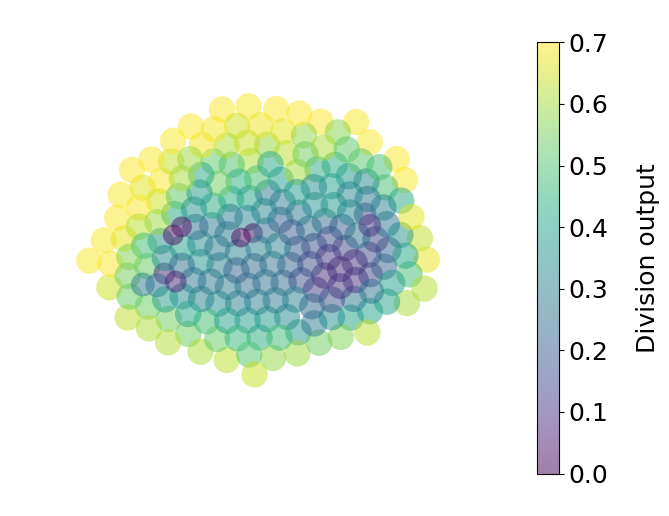

In [71]:
div_outputs = transform_fwd_inv(opt_peaks_fstate, opt_peaks_fstate.divrate)
draw_circles(opt_peaks_fstate, div_outputs, cm=plt.cm.viridis, cbar_title="Division output", min_val=0.0, max_val=0.7);
plt.savefig('../data/paper/figures/twopeaks_opt_divoutputs.svg')

In [22]:
def off_center_chemfield(state, params, fspace, chem_max=50.0, chem_k=1.0):
    center = np.array([-4.0, 0.0])
    chemfield_disp = vmap(fspace.displacement, (0, None))(state.position, center)
    chemfield_disp = np.linalg.norm(chemfield_disp, axis=1)
    # TODO: Write these out as params
    chemfield = 100/(2 + 0.8*np.power(chemfield_disp, 2.0))
    chemfield = np.where(state.celltype > 0, chemfield, 0.0) #+ noise*random.normal(istate.key, chemfield.shape)
    state = jdc.replace(state, field=chemfield)
    return state

In [63]:
uopt_off_fstate = run_sim_field(key, 0.0, 0.0, off_center_chemfield, sim_init, sim_step, params, istate, 100)
opt_off_fstate = run_sim_field(key, 0.0, 0.0, off_center_chemfield, sim_init, sim_step, params_all[0], istate, 100)

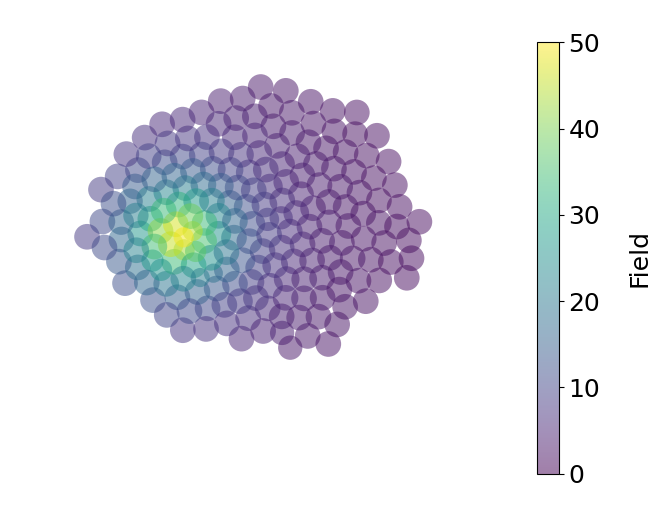

In [64]:
draw_circles(uopt_off_fstate, uopt_off_fstate.field, min_val=0.0, max_val=50.0, cm=plt.cm.viridis, cbar_title="Field");
plt.savefig('../data/paper/figures/offcenter_unopt_field.svg')

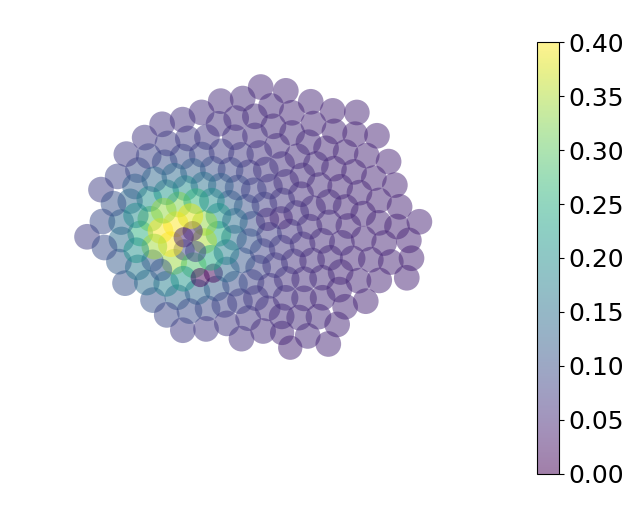

In [66]:
draw_circles(uopt_off_fstate, uopt_off_fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.4);
plt.savefig('../data/paper/figures/offcenter_unopt_divrates.svg')

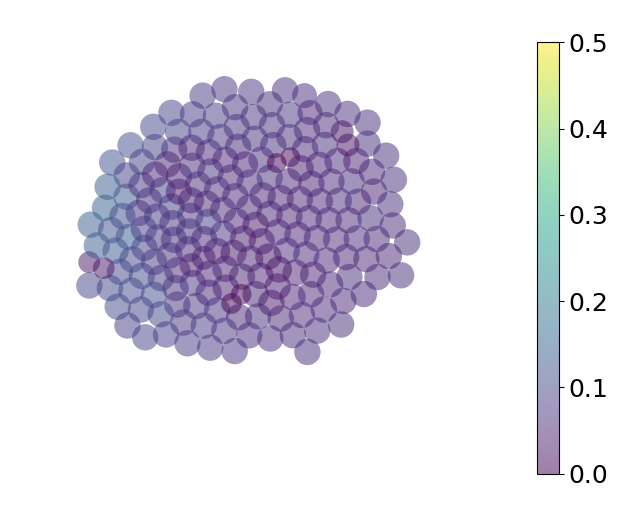

In [67]:
draw_circles(opt_off_fstate, opt_off_fstate.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.5);
plt.savefig('../data/paper/figures/offcenter_opt_divrates.svg')

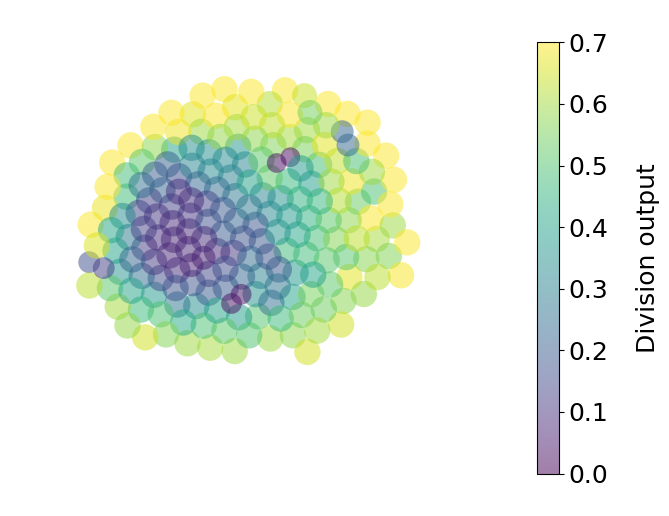

In [72]:
div_outputs = transform_fwd_inv(opt_off_fstate, opt_off_fstate.divrate)
draw_circles(opt_off_fstate, div_outputs, cm=plt.cm.viridis, cbar_title="Division output", min_val=0.0, max_val=0.7);
plt.savefig('../data/paper/figures/offcenter_opt_divoutputs.svg')

In [27]:
# Run 100 optimizations with each field type
keys = random.split(key, 100)
gradfield = run_sim_field_vmap(keys[:50], 0.0, 0.0, gradient_chemfield, sim_init, sim_step, params, istate, 100)
gradfield_opt = run_sim_field_vmap(keys[50:], 0.0, 0.0, gradient_chemfield, sim_init, sim_step, params_all[0], istate, 100)
twopeaks = run_sim_field_vmap(keys[:50], 0.0, 0.0, two_peaks_chemfield, sim_init, sim_step, params, istate, 100)
twopeaks_opt = run_sim_field_vmap(keys[50:], 0.0, 0.0, two_peaks_chemfield, sim_init, sim_step, params_all[0], istate, 100)
offcenter = run_sim_field_vmap(keys[:50], 0.0, 0.0, off_center_chemfield, sim_init, sim_step, params, istate, 100)
offcenter_opt = run_sim_field_vmap(keys[50:], 0.0, 0.0, off_center_chemfield, sim_init, sim_step, params_all[0], istate, 100)
exponential = run_sim_field_vmap(keys[:50], 1.0, 50.0, exp_chemfield, sim_init, sim_step, params, istate, 100)
exponential_opt = run_sim_field_vmap(keys[50:], 1.0, 50.0, exp_chemfield, sim_init, sim_step, params_all[0], istate, 100)
powerlaw = run_sim_field_vmap(keys[:50], 1.0, 50.0, power_chemfield, sim_init, sim_step, params, istate, 100)
powerlaw_opt = run_sim_field_vmap(keys[50:], 1.0, 50.0, power_chemfield, sim_init, sim_step, params_all[0], istate, 100)

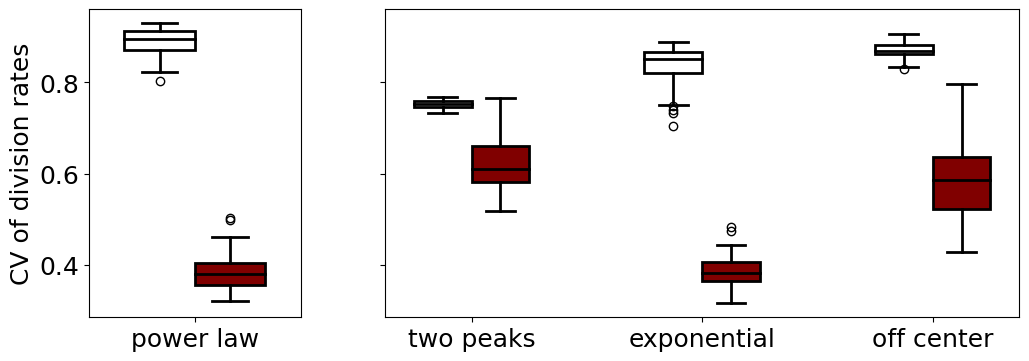

In [43]:
# Make one boxplot of CV of division rates for each field type, unoptimized and optimized
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True, width_ratios=[1, 3])
boxplots = ax[1].boxplot([np.std(twopeaks.divrate, axis=1)/np.mean(twopeaks.divrate, axis=1), 
                np.std(twopeaks_opt.divrate, axis=1)/np.mean(twopeaks_opt.divrate, axis=1),
                np.std(exponential.divrate, axis=1)/np.mean(exponential.divrate, axis=1), 
                np.std(exponential_opt.divrate, axis=1)/np.mean(exponential_opt.divrate, axis=1),
                np.std(offcenter.divrate, axis=1)/np.mean(offcenter.divrate, axis=1), 
                np.std(offcenter_opt.divrate, axis=1)/np.mean(offcenter_opt.divrate, axis=1)],
            positions=[1, 1.5, 3, 3.5, 5, 5.5],
            widths=0.5,
            patch_artist=True);
boxplot_pl = ax[0].boxplot([np.std(powerlaw.divrate, axis=1)/np.mean(powerlaw.divrate, axis=1),
            np.std(powerlaw_opt.divrate, axis=1)/np.mean(powerlaw_opt.divrate, axis=1)],
            positions=[1, 1.5],
            widths=0.5,
            patch_artist=True);
labels=["two peaks", 
        "exponential",
        "off center"]
ax[0].set_xticks(ticks=[1.25,], labels=["power law"])
ax[1].set_xticks(ticks=[1.25, 3.25, 5.25], labels=labels)

box_colors=["white", "maroon"]
line_colors = ["black", "black"]
for i, box in enumerate(boxplot_pl['boxes']):
    box.set_facecolor(box_colors[i])
    box.set_edgecolor(line_colors[i])
    box.set_linewidth(2)
    boxplot_pl['medians'][i].set(color=line_colors[i], linewidth=2)
    boxplot_pl['whiskers'][i * 2].set(color=line_colors[i], linewidth=2)
    boxplot_pl['whiskers'][i * 2 + 1].set(color=line_colors[i], linewidth=2)
    boxplot_pl['caps'][i * 2].set(color=line_colors[i], linewidth=2)
    boxplot_pl['caps'][i * 2 + 1].set(color=line_colors[i], linewidth=2)

box_colors=["white", "maroon", "white", "maroon", "white", "maroon"]
line_colors = ["black", "black", "black", "black", "black", "black"]
for i, box in enumerate(boxplots['boxes']):
    box.set_facecolor(box_colors[i])
    box.set_edgecolor(line_colors[i])
    box.set_linewidth(2)
    boxplots['medians'][i].set(color=line_colors[i], linewidth=2)
    boxplots['whiskers'][i * 2].set(color=line_colors[i], linewidth=2)
    boxplots['whiskers'][i * 2 + 1].set(color=line_colors[i], linewidth=2)
    boxplots['caps'][i * 2].set(color=line_colors[i], linewidth=2)
    boxplots['caps'][i * 2 + 1].set(color=line_colors[i], linewidth=2)
    
ax[0].set_ylabel("CV of division rates")
plt.savefig('../data/paper/figures/field_boxplot.svg')

# Ablation Experiments

In [165]:
import copy

In [166]:
# Set chemical input weights to zero in the hidden state network and run forward simulation
# Order: chemical, chemgrads, stress
chem_inds = [0, 1, 2, 3, 4, 5]
stress_inds = [6]

ablate_chem_p = copy.deepcopy(opt_params)
ablate_chem_p["hidden_fn"]['mlp/~/linear_0']['w'] = ablate_chem_p["hidden_fn"]['mlp/~/linear_0']['w'].at[chem_inds, :].set(np.zeros((len(chem_inds), 8)))

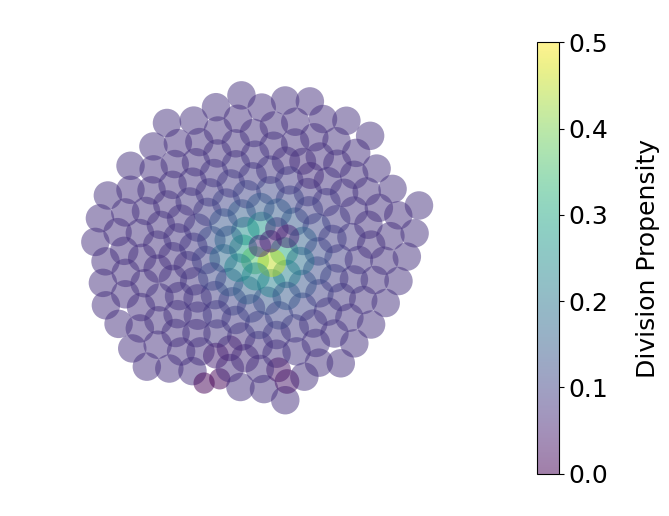

In [48]:
sim_init, sim_step = simulation(sim.fstep, eqx.combine(ablate_chem_p, Dparams), fspace)
fstate_opt, _ = sim_trajectory(istate, sim_init, sim_step, 100, key, history=False)
draw_circles(fstate_opt, fstate_opt.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.5, cbar_title="Division Propensity");

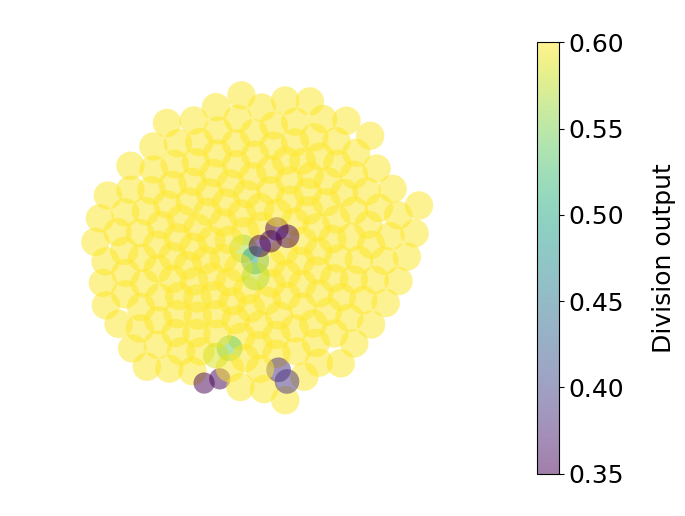

In [49]:
div_outputs = transform_fwd_inv(fstate_opt, fstate_opt.divrate)
draw_circles(fstate_opt, div_outputs, cm=plt.cm.viridis, cbar_title="Division output", min_val=0.35, max_val=0.6);

In [76]:
ablate_stress_p = copy.deepcopy(params_all[0])
ablate_stress_p["hidden_fn"]['mlp/~/linear_0']['w'] = ablate_stress_p["hidden_fn"]['mlp/~/linear_0']['w'].at[stress_inds, :].set(np.zeros((len(stress_inds), 8)))

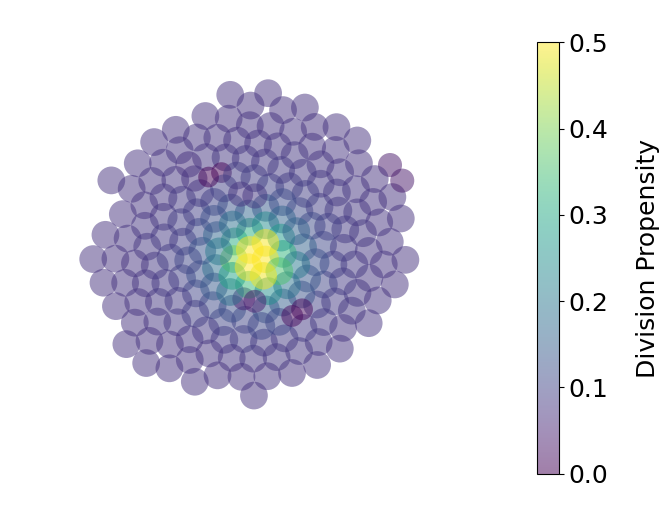

In [55]:
sim_init, sim_step = simulation(fstep, eqx.combine(ablate_stress_p, params), fspace)
fstate_opt, _ = sim_trajectory(istate, sim_init, sim_step, 100, key, history=False)
draw_circles(fstate_opt, fstate_opt.divrate, cm=plt.cm.viridis, min_val=0.0, max_val=0.5, cbar_title="Division Propensity");

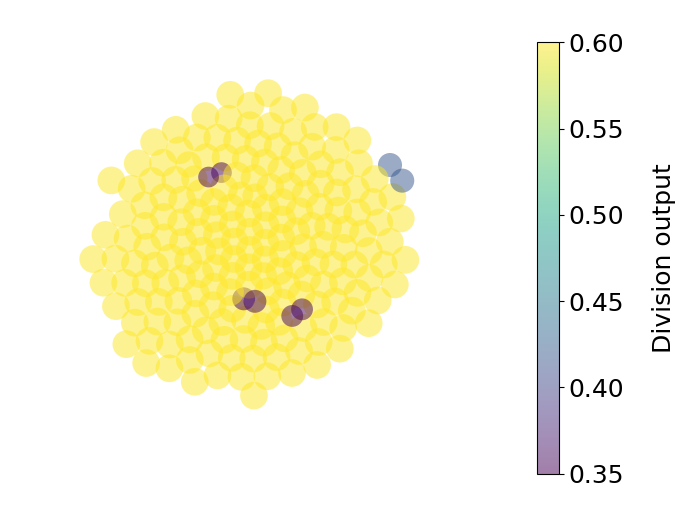

In [56]:
div_outputs = transform_fwd_inv(fstate_opt, fstate_opt.divrate)
draw_circles(fstate_opt, div_outputs, cm=plt.cm.viridis, cbar_title="Division output", min_val=0.35, max_val=0.6);

In [77]:
keys = random.split(key, 400)
unopt_fstates = run_sim_vmap(keys[:100], sim_init, sim_step, params, istate, 100)
opt_fstates = run_sim_vmap(keys[100:200], sim_init, sim_step, params_all[0], istate, 100)
opt_chem_ab_fstates = run_sim_vmap(keys[200:300], sim_init, sim_step, ablate_chem_p, istate, 100)
opt_stress_ab_fstates = run_sim_vmap(keys[300:], sim_init, sim_step, ablate_stress_p, istate, 100)

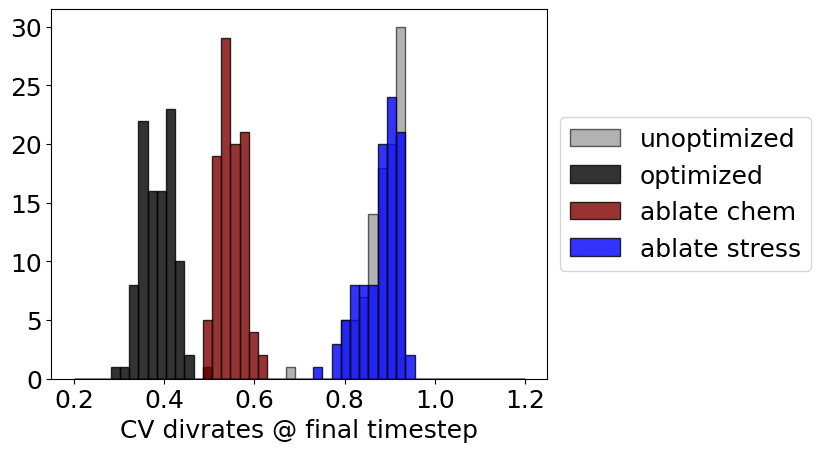

In [82]:
plt.hist(np.std(unopt_fstates.divrate, axis=1)/np.mean(unopt_fstates.divrate, axis=1), bins=np.linspace(0.2, 1.2, 50), edgecolor='black', label="unoptimized", color="gray", alpha=0.6);
plt.hist(np.std(opt_fstates.divrate, axis=1)/np.mean(opt_fstates.divrate, axis=1), bins=np.linspace(0.2, 1.2, 50), edgecolor='black', label="optimized", color="black", alpha=0.8);
plt.hist(np.std(opt_chem_ab_fstates.divrate, axis=1)/np.mean(opt_chem_ab_fstates.divrate, axis=1), bins=np.linspace(0.2, 1.2, 50), edgecolor='black', label="ablate chem", color="maroon", alpha=0.8);
plt.hist(np.std(opt_stress_ab_fstates.divrate, axis=1)/np.mean(opt_stress_ab_fstates.divrate, axis=1), bins=np.linspace(0.2, 1.2, 50), edgecolor='black', label="ablate stress", color="blue", alpha=0.8);
plt.xlabel("CV divrates @ final timestep");
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('../data/paper/figures/ablations_plot.svg')

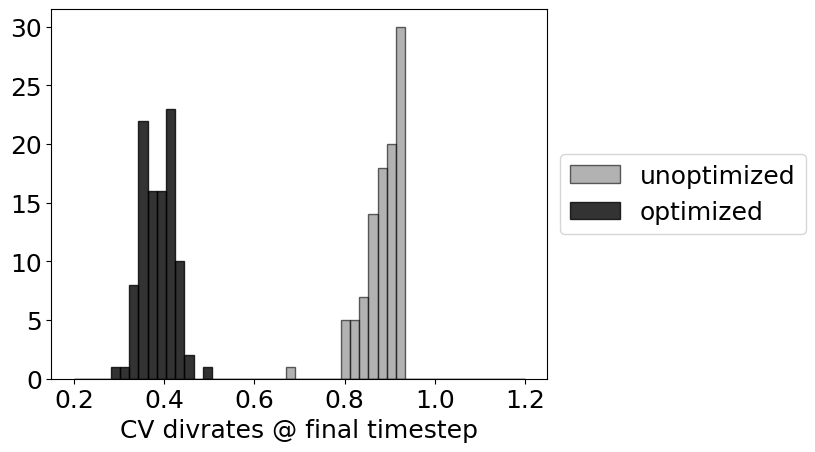

In [83]:
plt.hist(np.std(unopt_fstates.divrate, axis=1)/np.mean(unopt_fstates.divrate, axis=1), bins=np.linspace(0.2, 1.2, 50), edgecolor='black', label="unoptimized", color="gray", alpha=0.6);
plt.hist(np.std(opt_fstates.divrate, axis=1)/np.mean(opt_fstates.divrate, axis=1), bins=np.linspace(0.2, 1.2, 50), edgecolor='black', label="optimized", color="black", alpha=0.8);
plt.xlabel("CV divrates @ final timestep");
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.savefig('../data/paper/figures/histograms_plot.svg')

# Synthetic circuit

In [221]:
from Ramya.utils.gene_utils import default_params, build_sim_from_params, run_optimization

In [246]:
Dparams, Dtrain_params = default_params(init_key)
Dparams["ncells_init"] = 100
Dparams["ncells_add"] = 100
Dparams["chem_max"] = 50.0
Dtrain_params["chem_max"] = False
transform_fwd = lambda state, divrates: divrates*state.field

In [247]:
sim = build_sim_from_params(Dparams, Dtrain_params, subkey, div_fwd=transform_fwd)
fstep = sim.fstep + [S_fixed_chemfield]

In [248]:
sim_init, sim_step = simulation(fstep, sim.params, sim.fspace)
fstate, _ = sim_trajectory(sim.istate, sim_init, sim_step, 100, key, history=False)

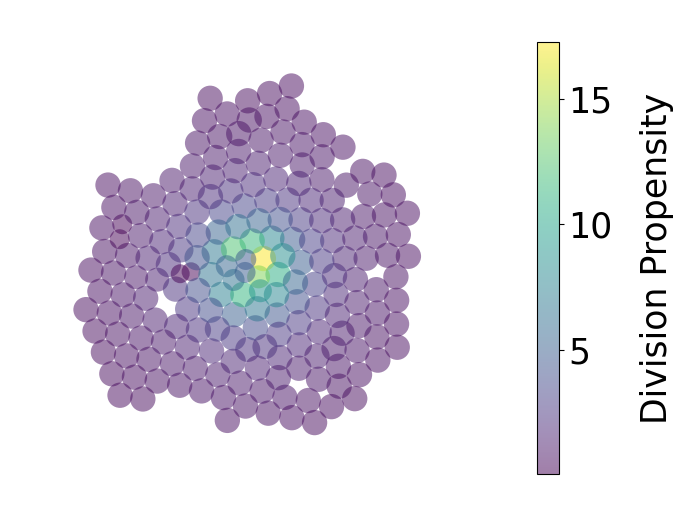

In [249]:
draw_circles(fstate, fstate.divrate, cm=plt.cm.viridis, normalize=False, cbar_title="Division Propensity");

In [251]:
def cv_divrates(state):
    return np.std(state.divrate)/(np.mean(state.divrate) + 1e-6)

In [252]:
from collections import namedtuple
SimulBlocks = namedtuple('SimulBlocks', ['fstep', 'fspace', 'istate', 'params', 'train_params'])
sim = SimulBlocks(fstep, sim.fspace, sim.istate, sim.params, sim.train_params) #, sim_init, sim_step

In [253]:
EPOCHS = 100
EPISODES_PER_UPDATE = 8
EPISODES_PER_EVAL = 64

LEARNING_RATE = 3e-2
METRIC_FN = cv_divrates

SAVE_EVERY = 1

key, train_key = random.split(random.PRNGKey(0))
loss_t, params_t, _ = run_optimization(train_key,
                                       sim,
                                       METRIC_FN,
                                       metric_type='cost',
                                       epochs=EPOCHS,
                                       episodes_per_update=EPISODES_PER_UPDATE,
                                       episodes_per_eval=EPISODES_PER_EVAL,
                                       learning_rate=LEARNING_RATE,
                                       save_every=SAVE_EVERY,
                                       LAMBDA=1e-3,
                                       reinforce_gamma=0.99
                                       )


Loss: 1.7538: 100%|███████████████████████████████████████████████████| 100/100 [06:05<00:00,  3.66s/it]


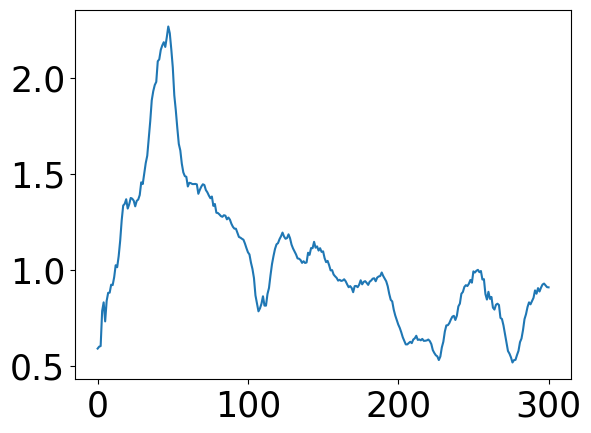

In [245]:
plt.plot(loss_t);